In [63]:
# Import Time
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import scipy.stats as stats
from scipy.stats import ttest_ind

In [2]:
# Read in the raw data from Zillow
inventory_df = pd.read_csv(Path("resources/invt_all.csv")) #Inventory - All tiers
saleprice_df = pd.read_csv(Path("resources/median_sale_price_all.csv")) #Median Sale Price - All tiers
zori_df = pd.read_csv(Path("resources/zori_all.csv")) #Zillow Observed Rent Index - All tiers
zhvi_low_df = pd.read_csv(Path("resources/zhvi_low.csv")) #Zillow Home Value Index - Low Tier
zhvi_mid_df = pd.read_csv(Path("resources/zhvi_mid.csv")) #Zillow Home Value Index - Mid Tier
zhvi_top_df = pd.read_csv(Path("resources/zhvi_top.csv")) #Zillow Home Value Index - Top Tier

### Data Preprocessing Script

**Inventory dataset preprocessing**

In [3]:
# Read the Inventory DataFrame
inventory_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,...,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30
0,102001,0,United States,country,NaN,1360756.0,1388126.0,1515702.0,1596751.0,1664788.0,...,1077709.0,1056644.0,963356.0,847668.0,841363.0,803900.0,861023.0,872580.0,907907.0,939926.0
1,394913,1,"New York, NY",msa,NY,66530.0,74575.0,80016.0,86445.0,91131.0,...,58995.0,56084.0,51270.0,43845.0,42633.0,41911.0,45216.0,45463.0,46808.0,46268.0
2,753899,2,"Los Angeles, CA",msa,CA,19893.0,21994.0,24106.0,25253.0,27455.0,...,21529.0,20888.0,19013.0,15910.0,15377.0,14858.0,15407.0,15043.0,15398.0,15652.0
3,394463,3,"Chicago, IL",msa,IL,34633.0,37046.0,44063.0,45649.0,47560.0,...,30791.0,29600.0,25921.0,21500.0,20889.0,20098.0,21779.0,21766.0,22727.0,23607.0
4,394514,4,"Dallas, TX",msa,TX,23048.0,23331.0,25749.0,28549.0,30376.0,...,22442.0,21856.0,20203.0,17895.0,17582.0,15841.0,17736.0,20300.0,21925.0,22968.0


In [4]:
# Obtain basic information on the dataset
inventory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928 entries, 0 to 927
Data columns (total 71 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionID    928 non-null    int64  
 1   SizeRank    928 non-null    int64  
 2   RegionName  928 non-null    object 
 3   RegionType  928 non-null    object 
 4   StateName   927 non-null    object 
 5   2018-01-31  899 non-null    float64
 6   2018-02-28  899 non-null    float64
 7   2018-03-31  899 non-null    float64
 8   2018-04-30  899 non-null    float64
 9   2018-05-31  899 non-null    float64
 10  2018-06-30  900 non-null    float64
 11  2018-07-31  900 non-null    float64
 12  2018-08-31  900 non-null    float64
 13  2018-09-30  900 non-null    float64
 14  2018-10-31  900 non-null    float64
 15  2018-11-30  900 non-null    float64
 16  2018-12-31  900 non-null    float64
 17  2019-01-31  900 non-null    float64
 18  2019-02-28  900 non-null    float64
 19  2019-03-31  900 non-null    f

In [5]:
# See if there is missing data and address as needed
total_fields = inventory_df.size
missing_fields = (inventory_df.isnull().sum()).sum()
rate = (missing_fields / total_fields) * 100
if rate <= 5.00:
    print(f'Error rate is less than 5% ({rate:.2f}%)')
else:
    print(f'Dataset has a {rate:.2f}% missing data rate')

Error rate is less than 5% (1.91%)


**Saleprice dataset preprocessing**

In [6]:
# Read the Sale Price DataFrame
saleprice_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,...,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31
0,102001,0,United States,country,NaN,180000.0,185000.0,186900.0,189000.0,195000.0,...,345000.0,340000.0,335000.0,325000.0,320000.0,320000.0,330000.0,340000.0,350000.0,360000.0
1,394913,1,"New York, NY",msa,NY,401251.0,395500.0,400000.0,400000.0,405000.0,...,570000.0,545000.0,525000.0,522250.0,513765.0,520000.0,505050.0,515250.0,540000.0,565000.0
2,753899,2,"Los Angeles, CA",msa,CA,500000.0,495000.0,500000.0,490000.0,481250.0,...,865000.0,850000.0,841000.0,830000.0,810000.0,815000.0,825000.0,841750.0,850000.0,869000.0
3,394463,3,"Chicago, IL",msa,IL,237000.0,242000.0,239000.0,244000.0,254750.0,...,295000.0,285000.0,275000.0,275000.0,270000.0,270000.0,275000.0,295000.0,305000.0,319000.0
4,394514,4,"Dallas, TX",msa,TX,137000.0,146700.0,144000.0,149900.0,155000.0,...,399500.0,387900.0,385000.0,375000.0,360000.0,355000.0,372000.0,374500.0,385000.0,395000.0


In [7]:
# Obtain basic information on the dataset
saleprice_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647 entries, 0 to 646
Columns: 189 entries, RegionID to 2023-05-31
dtypes: float64(184), int64(2), object(3)
memory usage: 955.5+ KB


In [8]:
# See if there is missing data and address as needed
total_fields = saleprice_df.size
missing_fields = (saleprice_df.isnull().sum()).sum()
rate = (missing_fields / total_fields) * 100
if rate <= 5.00:
    print(f'Error rate is less than 5% ({rate:.2f}%)')
else:
    print(f'Dataset has a {rate:.2f}% missing data rate')

Dataset has a 22.85% missing data rate


In [9]:
# See if there is missing data and address as needed
saleprice_df.isnull().sum()

RegionID       0
SizeRank       0
RegionName     0
RegionType     0
StateName      1
              ..
2023-01-31    69
2023-02-28    52
2023-03-31    24
2023-04-30    17
2023-05-31     0
Length: 189, dtype: int64

**Observed Rent Index dataset preprocessing**

In [10]:
# Read the Observed Rent Index DataFrame
zori_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,...,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30
0,102001,0,United States,country,NaN,1300.062229,1307.080005,1316.310356,1326.393130,1336.439921,...,2014.250561,2014.094708,2009.012292,2005.244310,2005.033366,2010.012117,2018.271884,2029.329407,2042.199479,2053.895556
1,394913,1,"New York, NY",msa,NY,2475.313804,2491.999171,2510.649267,2534.100262,2550.171304,...,3332.655016,3313.507710,3276.931534,3251.478248,3243.246585,3259.055030,3285.399008,3324.429687,3365.688061,3404.838967
2,753899,2,"Los Angeles, CA",msa,CA,1904.292137,1916.483629,1932.049652,1946.294240,1961.089204,...,2957.369106,2955.110308,2946.882246,2940.446816,2935.179864,2940.045800,2949.136280,2964.319666,2972.332684,2982.773017
3,394463,3,"Chicago, IL",msa,IL,1488.968336,1497.098751,1508.713686,1519.510776,1530.903848,...,1957.170145,1957.457287,1953.219199,1954.529453,1959.161341,1971.783036,1985.314746,2002.652499,2027.425159,2049.848565
4,394514,4,"Dallas, TX",msa,TX,1160.170399,1165.080157,1173.252310,1183.978198,1194.746162,...,1857.557867,1847.884074,1837.851422,1827.707540,1823.280236,1825.236843,1830.939832,1835.257698,1842.765673,1852.860051


In [11]:
# Obtain basic information on the dataset
zori_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 0 to 621
Columns: 107 entries, RegionID to 2023-06-30
dtypes: float64(102), int64(2), object(3)
memory usage: 520.1+ KB


In [12]:
# See if there is missing data and address as needed
total_fields = zori_df.size
missing_fields = (zori_df.isnull().sum()).sum()
rate = (missing_fields / total_fields) * 100
if rate <= 5.00:
    print(f'Error rate is less than 5% ({rate:.2f}%)')
else:
    print(f'Dataset has a {rate:.2f}% missing data rate')

Dataset has a 48.05% missing data rate


In [13]:
# See if there is missing data and address as needed
zori_df.isnull().sum()

RegionID        0
SizeRank        0
RegionName      0
RegionType      0
StateName       1
             ... 
2023-02-28    162
2023-03-31    136
2023-04-30    111
2023-05-31     65
2023-06-30      0
Length: 107, dtype: int64

**Zillow Home Value Index dataset preprocessing**

In [14]:
# A note on the ZHVI:
    # ZHVI represents the “typical” home value for a region. 
    # It’s calculated as a weighted average of the middle third of homes in a given region. 
    # The typical home value for the region is NOT the “median home value.”

In [15]:
# Merge the three ZHVI datasets (columns without the subscript are Mid Tier)
df_1 = pd.merge(zhvi_low_df, zhvi_top_df, on="RegionID", suffixes=("_low","_top"))
zhvi_all_df = pd.merge(df_1, zhvi_mid_df, on="RegionID")

zhvi_all_df.head()

,RegionID,SizeRank_low,RegionName_low,RegionType_low,StateName_low,2000-01-31_low,2000-02-29_low,2000-03-31_low,2000-04-30_low,2000-05-31_low,...,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30
0,102001,0,United States,country,NaN,48205.157126,48277.602146,48370.517257,48576.973316,48823.732994,...,343163.762567,341495.863150,338680.235873,334380.232063,334104.950911,334255.303781,337164.650040,340651.000511,345348.135519,350212.518429
1,394913,1,"New York, NY",msa,NY,102107.057069,102506.922494,102897.973204,103709.380919,104559.587219,...,597814.714791,595366.022117,592449.452080,585536.591188,589612.342031,590313.476222,593300.529394,598374.486199,607537.383282,617791.645472
2,753899,2,"Los Angeles, CA",msa,CA,124854.660790,125220.426299,125798.067126,126949.232583,128261.422042,...,886239.620947,878189.809467,869918.808280,857676.526998,851842.449813,853030.136536,862696.711890,872057.545426,886061.795424,902809.343544
3,394463,3,"Chicago, IL",msa,IL,57482.934649,57529.898148,57627.649694,57848.486019,58118.096926,...,295446.085115,293927.114794,291500.374718,287854.849568,289641.216564,288989.250174,291189.289450,295620.503018,301140.510067,307485.214569
4,394514,4,"Dallas, TX",msa,TX,63433.381496,63451.170753,63463.701517,63527.553952,63635.820449,...,380848.306668,377472.021732,372964.299358,367078.695043,364430.244332,364007.460253,366353.967688,369210.684274,373183.374727,376958.721618


In [16]:
# Merging the datasets created duplicate columns that can be dropped
zhvi_all_df.drop(['SizeRank', 'RegionName', 'RegionType', 'StateName', 
                 'SizeRank_top', 'RegionName_top', 'RegionType_top', 'StateName_top'], 
                 axis=1, inplace=True
                )
zhvi_all_df.columns

Index(['RegionID', 'SizeRank_low', 'RegionName_low', 'RegionType_low',
       'StateName_low', '2000-01-31_low', '2000-02-29_low', '2000-03-31_low',
       '2000-04-30_low', '2000-05-31_low',
       ...
       '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31', '2023-01-31',
       '2023-02-28', '2023-03-31', '2023-04-30', '2023-05-31', '2023-06-30'],
      dtype='object', length=898)

In [17]:
# Rename the datatype columns that have x_low on them
zhvi_all_df.rename(columns=
{
    'SizeRank_low': 'SizeRank',
    'RegionName_low': 'RegionName',
    'RegionType_low': 'RegionType',
    'StateName_low': 'StateName'
}, inplace=True)

zhvi_all_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31_low,2000-02-29_low,2000-03-31_low,2000-04-30_low,2000-05-31_low,...,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30
0,102001,0,United States,country,NaN,48205.157126,48277.602146,48370.517257,48576.973316,48823.732994,...,343163.762567,341495.863150,338680.235873,334380.232063,334104.950911,334255.303781,337164.650040,340651.000511,345348.135519,350212.518429
1,394913,1,"New York, NY",msa,NY,102107.057069,102506.922494,102897.973204,103709.380919,104559.587219,...,597814.714791,595366.022117,592449.452080,585536.591188,589612.342031,590313.476222,593300.529394,598374.486199,607537.383282,617791.645472
2,753899,2,"Los Angeles, CA",msa,CA,124854.660790,125220.426299,125798.067126,126949.232583,128261.422042,...,886239.620947,878189.809467,869918.808280,857676.526998,851842.449813,853030.136536,862696.711890,872057.545426,886061.795424,902809.343544
3,394463,3,"Chicago, IL",msa,IL,57482.934649,57529.898148,57627.649694,57848.486019,58118.096926,...,295446.085115,293927.114794,291500.374718,287854.849568,289641.216564,288989.250174,291189.289450,295620.503018,301140.510067,307485.214569
4,394514,4,"Dallas, TX",msa,TX,63433.381496,63451.170753,63463.701517,63527.553952,63635.820449,...,380848.306668,377472.021732,372964.299358,367078.695043,364430.244332,364007.460253,366353.967688,369210.684274,373183.374727,376958.721618


In [18]:
# See if there is missing data and address as needed
total_fields = zhvi_all_df.size
missing_fields = (zhvi_all_df.isnull().sum()).sum()
rate = (missing_fields / total_fields) * 100
if rate <= 5.00:
    print(f'Error rate is less than 5% ({rate:.2f}%)')
else:
    print(f'Dataset has a {rate:.2f}% missing data rate')

Dataset has a 18.32% missing data rate


### Exploratory Data Analysis (EDA)

**EDA for the Inventory dataset**

In [19]:
# Display the Inventory DataFrame
inventory_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,...,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30
0,102001,0,United States,country,NaN,1360756.0,1388126.0,1515702.0,1596751.0,1664788.0,...,1077709.0,1056644.0,963356.0,847668.0,841363.0,803900.0,861023.0,872580.0,907907.0,939926.0
1,394913,1,"New York, NY",msa,NY,66530.0,74575.0,80016.0,86445.0,91131.0,...,58995.0,56084.0,51270.0,43845.0,42633.0,41911.0,45216.0,45463.0,46808.0,46268.0
2,753899,2,"Los Angeles, CA",msa,CA,19893.0,21994.0,24106.0,25253.0,27455.0,...,21529.0,20888.0,19013.0,15910.0,15377.0,14858.0,15407.0,15043.0,15398.0,15652.0
3,394463,3,"Chicago, IL",msa,IL,34633.0,37046.0,44063.0,45649.0,47560.0,...,30791.0,29600.0,25921.0,21500.0,20889.0,20098.0,21779.0,21766.0,22727.0,23607.0
4,394514,4,"Dallas, TX",msa,TX,23048.0,23331.0,25749.0,28549.0,30376.0,...,22442.0,21856.0,20203.0,17895.0,17582.0,15841.0,17736.0,20300.0,21925.0,22968.0


**Question 1: What does housing inventory in Arizona look like?**

In [20]:
# Create a Summary Table of the MSA of Arizona for current inventory
az_summary = inventory_df.loc[inventory_df["StateName"] == "AZ"]
az_summary = az_summary[['RegionName','SizeRank', '2023-06-30']]
az_summary.reset_index(drop=True, inplace=True)

# Rename Columns
az_summary.rename(columns = {"SizeRank":"Population Rank",
                            "RegionName": "Metro Area",
                            "2023-06-30": "Current Inventory June 2023"
                            }, inplace=True)

# Create a column to show inventory as a percent
az_summary["As %"] = az_summary["Current Inventory June 2023"] / az_summary["Current Inventory June 2023"].sum() *100
az_summary["As %"] = az_summary["As %"].apply("{:.2f}%".format)
az_summary

,Metro Area,Population Rank,Current Inventory June 2023,As %
0,"Phoenix, AZ",11,16125.0,65.97%
1,"Tucson, AZ",54,2378.0,9.73%
2,"Prescott Valley, AZ",198,1452.0,5.94%
3,"Lake Havasu City, AZ",218,1569.0,6.42%
4,"Yuma, AZ",225,469.0,1.92%
5,"Flagstaff, AZ",302,596.0,2.44%
6,"Sierra Vista, AZ",335,547.0,2.24%
7,"Show Low, AZ",372,670.0,2.74%
8,"Payson, AZ",583,377.0,1.54%
9,"Nogales, AZ",625,177.0,0.72%


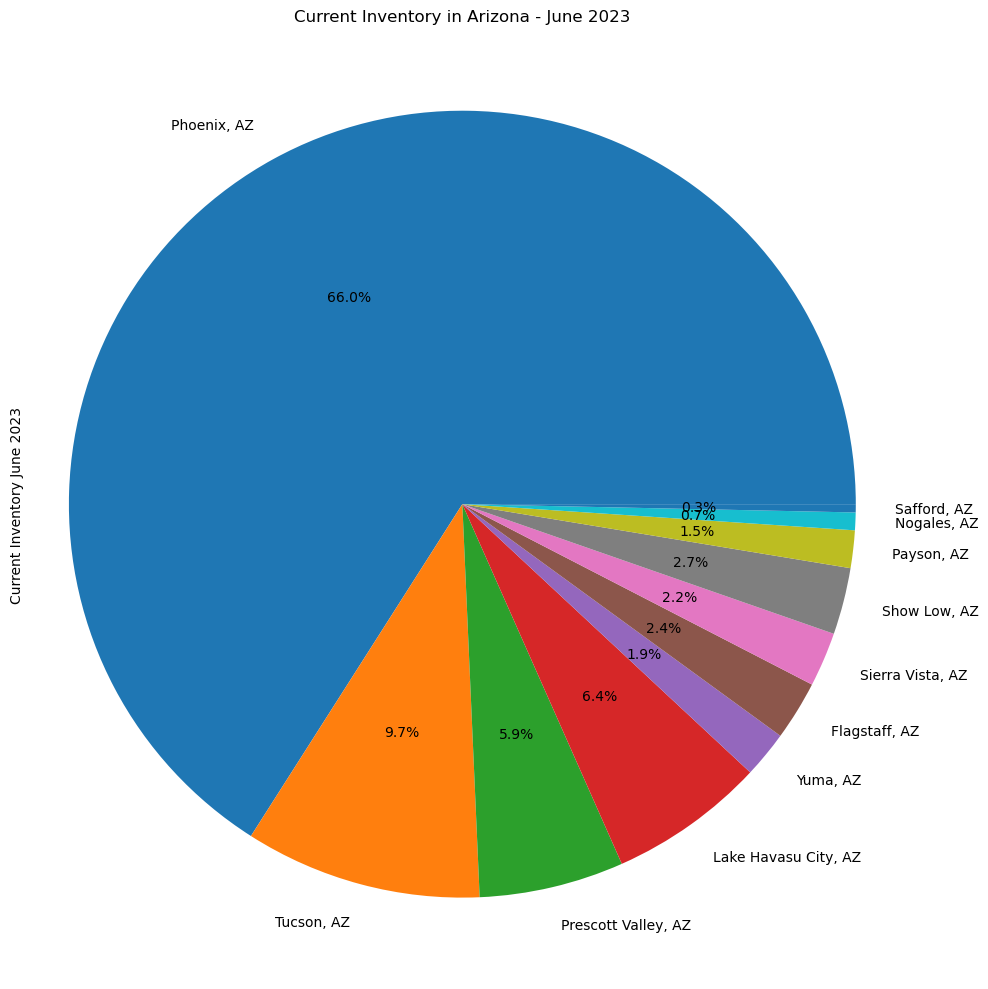

In [21]:
# Create a Pie Chart for Arizona MSA
az_summary.plot(kind='pie', y='Current Inventory June 2023',
                labels=az_summary["Metro Area"], autopct='%1.1f%%',
                title="Current Inventory in Arizona - June 2023",
                legend=False, figsize=(10, 10)
               )
plt.axis('equal')
plt.tight_layout()

# Show the pie chart
plt.show()

**How has inventory changed in the Phoenix MSA over the past five years?**

In [22]:
# Create an Phoenix specific DataFrame
phx_inv = inventory_df.loc[(inventory_df["RegionName"] == "Phoenix, AZ")]

# Using the printed list of columns, select the RegionName and dates only
phx_inv = phx_inv[['RegionName',
       '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31',
       '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31',
       '2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31',
       '2019-04-30', '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
       '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
       '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30',
       '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30',
       '2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
       '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31', '2021-09-30',
       '2021-10-31', '2021-11-30', '2021-12-31', '2022-01-31', '2022-02-28',
       '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30', '2022-07-31',
       '2022-08-31', '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
       '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30', '2023-05-31',
       '2023-06-30']]

# Transpose the dataset to make columns contain specific information to only the MSA
phx_t = phx_inv.transpose().reset_index()

# This will move the city name into the index and make the DataFrame more readable
phx_t.columns = phx_t.iloc[0]
phx_t = phx_t.iloc[1:]
phx_t.rename(columns = {"RegionName":"Date"}, inplace=True)

# Review the DataFrame
phx_t

,Date,"Phoenix, AZ"
1,2018-01-31,25768.0
2,2018-02-28,26865.0
3,2018-03-31,28519.0
4,2018-04-30,28333.0
5,2018-05-31,27669.0
...,...,...
62,2023-02-28,19896.0
63,2023-03-31,19846.0
64,2023-04-30,18567.0
65,2023-05-31,17171.0


In [23]:
# Convert Date to Datetime and remove duplicates
phx_t["Date"] = pd.to_datetime(phx_t["Date"])
phx_t = phx_t.loc[~phx_t.index.duplicated(keep='first')]

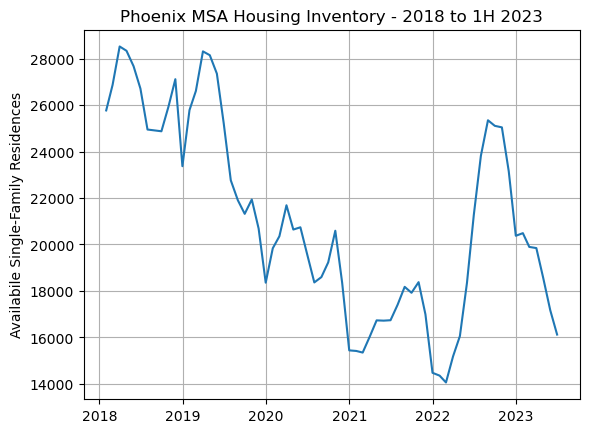

In [24]:
# Create lists to plot
date = phx_t["Date"]
phx = phx_t["Phoenix, AZ"]

# Create the plot
plt.plot(date, phx)

# Add chart elements
plt.title("Phoenix MSA Housing Inventory - 2018 to 1H 2023")
plt.ylabel("Availabile Single-Family Residences")
plt.grid(True)
plt.show()

**Is there a correlation to a MSA size and available inventory?**

In [25]:
# Bring up the AZ summary table
az_summary

,Metro Area,Population Rank,Current Inventory June 2023,As %
0,"Phoenix, AZ",11,16125.0,65.97%
1,"Tucson, AZ",54,2378.0,9.73%
2,"Prescott Valley, AZ",198,1452.0,5.94%
3,"Lake Havasu City, AZ",218,1569.0,6.42%
4,"Yuma, AZ",225,469.0,1.92%
5,"Flagstaff, AZ",302,596.0,2.44%
6,"Sierra Vista, AZ",335,547.0,2.24%
7,"Show Low, AZ",372,670.0,2.74%
8,"Payson, AZ",583,377.0,1.54%
9,"Nogales, AZ",625,177.0,0.72%


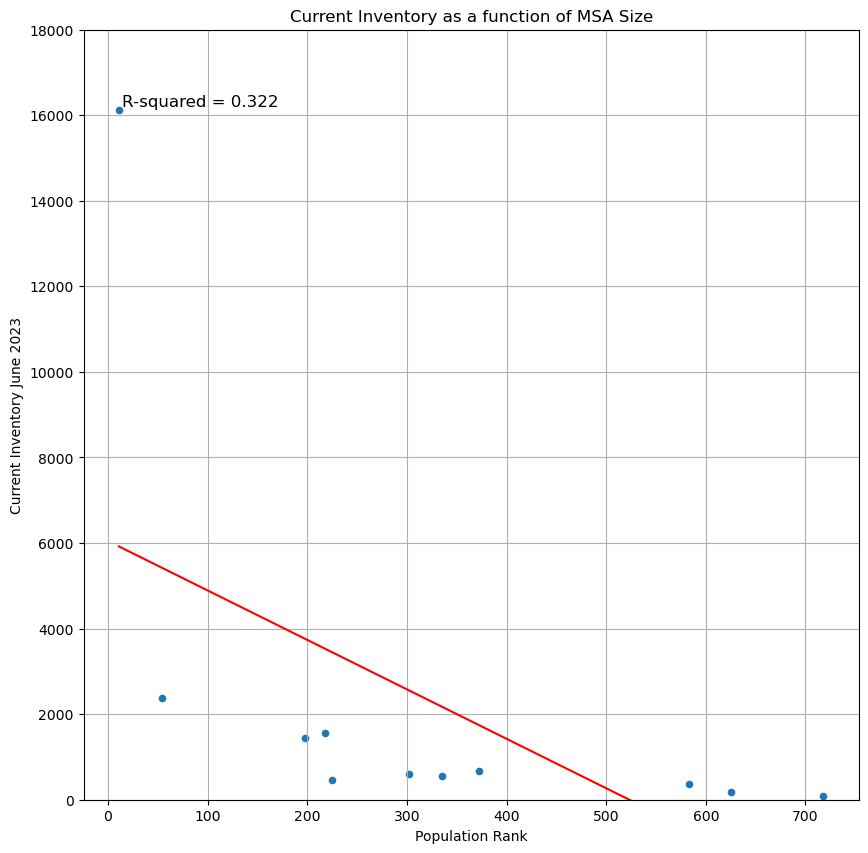

In [26]:
# Create the Scatter plot
az_summary.plot(kind="scatter", x="Population Rank", y="Current Inventory June 2023",
                title="Current Inventory as a function of MSA Size",
                legend=False, grid=True, figsize=(10, 10),
                )
plt.ylim(0, 18000)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(az_summary["Population Rank"],
                                                              az_summary["Current Inventory June 2023"])

# Calculate the R-squared value
r_squared = r_value ** 2

# Plot the regression line and display the R-squared
plt.plot(az_summary["Population Rank"], slope * az_summary["Population Rank"] + intercept, color="red")
plt.text(0.05, 0.9, f"R-squared = {r_squared:.3f}",transform=plt.gca().transAxes, fontsize=12)
plt.show()

**Question 2: How does Phoenix compare to similar MSA?**

* Compare Boston, San Francisco, Denver, Austin, and Phoenix
* Bar chart showing three time periods of inventory for the cities
* Scatter plot of inventory time series
* Bar chart showing three time periods of sales price for the cities
* Scatter of sale price time series

**How has inventory been trending in the five cities?**

In [27]:
# Create DataFrame that only contains the cities of interest
inv_select = inventory_df.loc[(inventory_df["RegionName"] == "Boston, MA") |
                            (inventory_df["RegionName"] == "Denver, CO") |
                            (inventory_df["RegionName"] == "San Francisco, CA") |
                            (inventory_df["RegionName"] == "Austin, TX") |
                            (inventory_df["RegionName"] == "Phoenix, AZ")
                           ]
inv_select

,RegionID,SizeRank,RegionName,RegionType,StateName,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,...,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30
10,394404,10,"Boston, MA",msa,MA,7993.0,8777.0,10432.0,12821.0,15297.0,...,10580.0,10375.0,8729.0,6332.0,6095.0,5836.0,7543.0,8073.0,8897.0,8537.0
11,394976,11,"Phoenix, AZ",msa,AZ,25768.0,26865.0,28519.0,28333.0,27669.0,...,25105.0,25039.0,23156.0,20375.0,20488.0,19896.0,19846.0,18567.0,17171.0,16125.0
12,395057,12,"San Francisco, CA",msa,CA,4111.0,5277.0,6589.0,7224.0,8162.0,...,8946.0,8645.0,7057.0,5001.0,4593.0,5010.0,5642.0,5955.0,6524.0,6347.0
19,394530,19,"Denver, CO",msa,CO,7401.0,7918.0,9478.0,10400.0,11502.0,...,10852.0,10263.0,8700.0,6988.0,6755.0,6576.0,7681.0,8116.0,8897.0,9845.0
29,394355,29,"Austin, TX",msa,TX,6704.0,7149.0,8322.0,9361.0,10047.0,...,12516.0,11992.0,10785.0,9333.0,9112.0,8833.0,10105.0,11084.0,11860.0,12332.0


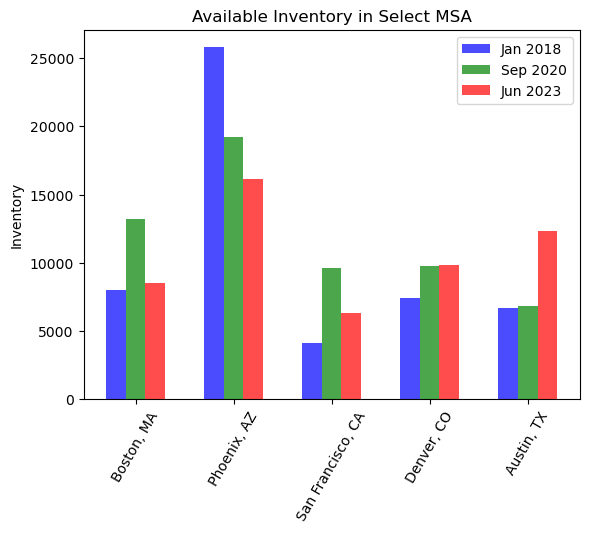

In [28]:
# Create Bar Chart showing inventory of the five cities for three different time periods
# Create an offset for each bar
bar_width = 0.2
offset = np.arange(len(inv_select['RegionName']))

# Plot all three y-values on the same graph with an offset for each bar
plt.bar(offset - bar_width, inv_select['2018-01-31'], width=bar_width, color='blue', alpha=0.7, label='Jan 2018')
plt.bar(offset, inv_select['2020-09-30'], width=bar_width, color='green', alpha=0.7, label='Sep 2020')
plt.bar(offset + bar_width, inv_select['2023-06-30'], width=bar_width, color='red', alpha=0.7, label='Jun 2023')

# Put labels and descriptors on the graph
plt.ylabel('Inventory')
plt.title('Available Inventory in Select MSA')
plt.xticks(offset, inv_select['RegionName'], rotation=60)
plt.legend()

# Display the plot
plt.show()

In [29]:
# Drop unnecessary values to make transpose easier
inv_select = inv_select.drop(['RegionID', 'SizeRank', 'RegionType', 'StateName'], axis=1)

# Transpose the dataset to make columns contain specific information to only the MSA
inv_t = inv_select.transpose().reset_index()

# This will move the city name into the index and make the DataFrame more readable
inv_t.columns = inv_t.iloc[0]
inv_t = inv_t.iloc[1:]
inv_t.rename(columns = {"RegionName":"Date"}, inplace=True)

# Review the DataFrame
inv_t

,Date,"Boston, MA","Phoenix, AZ","San Francisco, CA","Denver, CO","Austin, TX"
1,2018-01-31,7993.0,25768.0,4111.0,7401.0,6704.0
2,2018-02-28,8777.0,26865.0,5277.0,7918.0,7149.0
3,2018-03-31,10432.0,28519.0,6589.0,9478.0,8322.0
4,2018-04-30,12821.0,28333.0,7224.0,10400.0,9361.0
5,2018-05-31,15297.0,27669.0,8162.0,11502.0,10047.0
...,...,...,...,...,...,...
62,2023-02-28,5836.0,19896.0,5010.0,6576.0,8833.0
63,2023-03-31,7543.0,19846.0,5642.0,7681.0,10105.0
64,2023-04-30,8073.0,18567.0,5955.0,8116.0,11084.0
65,2023-05-31,8897.0,17171.0,6524.0,8897.0,11860.0


In [30]:
# Convert Date to Datetime and remove duplicates
inv_t["Date"] = pd.to_datetime(inv_t["Date"])
inv_t = inv_t.loc[~inv_t.index.duplicated(keep='first')]

# Break apart the DataFrame to make plotting easier
boston = inv_t[["Date", "Boston, MA"]]
phoenix = inv_t[["Date", "Phoenix, AZ"]]
sanfran = inv_t[["Date", "San Francisco, CA"]]
denver = inv_t[["Date", "Denver, CO"]]
austin = inv_t[["Date", "Austin, TX"]]

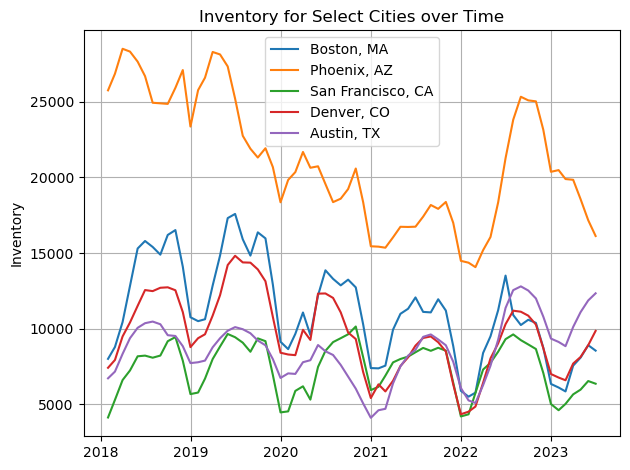

In [31]:
# Plot the inventory for each city
plt.plot(boston["Date"], boston["Boston, MA"], label="Boston, MA")
plt.plot(phoenix["Date"], phoenix["Phoenix, AZ"], label="Phoenix, AZ")
plt.plot(sanfran["Date"], sanfran["San Francisco, CA"], label="San Francisco, CA")
plt.plot(denver["Date"], denver["Denver, CO"], label="Denver, CO")
plt.plot(austin["Date"], austin["Austin, TX"], label="Austin, TX")

# Format the plot Area
plt.ylabel("Inventory")
plt.title("Inventory for Select Cities over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**How have Saleprices been trending in the five cities?**

In [32]:
# Filter out our Saleprice DataFrame to only display the five select cities
saleprice_select = saleprice_df.loc[(saleprice_df["RegionName"] == "Boston, MA") |
                            (saleprice_df["RegionName"] == "Denver, CO") |
                            (saleprice_df["RegionName"] == "San Francisco, CA") |
                            (saleprice_df["RegionName"] == "Austin, TX") |
                            (saleprice_df["RegionName"] == "Phoenix, AZ")
                           ]
saleprice_select

,RegionID,SizeRank,RegionName,RegionType,StateName,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,...,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31
10,394404,10,"Boston, MA",msa,MA,310000.0,329900.0,329000.0,344360.0,359900.0,...,630000.0,602000.0,589000.0,600000.0,570000.0,560000.0,550000.0,605000.0,627750.0,650500.0
11,394976,11,"Phoenix, AZ",msa,AZ,225000.0,225000.0,227000.0,227847.0,225000.0,...,458100.0,449000.0,449900.0,430000.0,415000.0,422000.0,422000.0,430000.0,434000.0,440000.0
12,395057,12,"San Francisco, CA",msa,CA,542000.0,535000.0,525000.0,515000.0,490000.0,...,1025000.0,1059750.0,1078000.0,1050000.0,940000.0,900000.0,919000.0,1038000.0,1080000.0,1100000.0
19,394530,19,"Denver, CO",msa,CO,225000.0,226000.0,227750.0,230000.0,235700.0,...,587225.0,585000.0,578000.0,566742.0,550000.0,537863.0,565000.0,574000.0,585000.0,598000.0
29,394355,29,"Austin, TX",msa,TX,178950.0,188000.0,184995.0,190000.0,192500.0,...,510000.0,495000.0,484000.0,470000.0,450000.0,460000.0,450000.0,462990.0,479495.0,480000.0


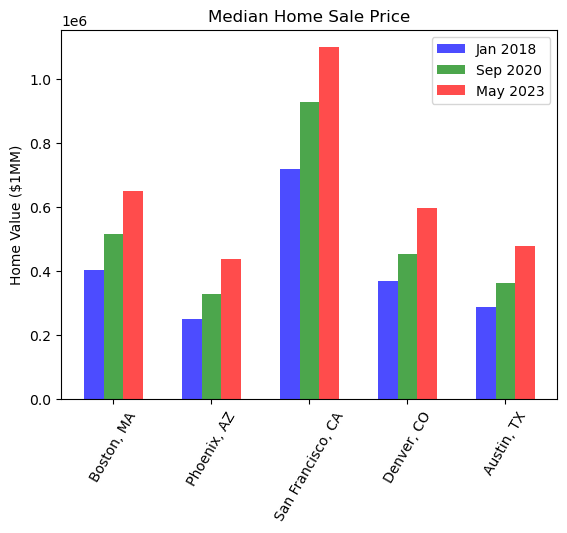

In [33]:
# Create Bar Chart showing sale price of the five cities for three different time periods
# Create an offset for each bar
bar_width = 0.2
offset = np.arange(len(saleprice_select['RegionName']))

# Plot all three y-values on the same graph with an offset for each bar
plt.bar(offset - bar_width, saleprice_select['2018-01-31'], width=bar_width, color='blue', alpha=0.7, label='Jan 2018')
plt.bar(offset, saleprice_select['2020-09-30'], width=bar_width, color='green', alpha=0.7, label='Sep 2020')
plt.bar(offset + bar_width, saleprice_select['2023-05-31'], width=bar_width, color='red', alpha=0.7, label='May 2023')

# Put labels and descriptors on the graph
plt.ylabel('Home Value ($1MM)')
plt.title('Median Home Sale Price')
plt.xticks(offset, saleprice_select['RegionName'], rotation=60)
plt.legend()

# Display the plot
plt.show()

In [34]:
# Drop unnecessary values to make transpose easier
saleprice_select = saleprice_select.drop(['RegionID', 'SizeRank', 'RegionType', 'StateName'], axis=1)

# Transpose the dataset to make columns contain specific information to only the MSA
saleprice_t = saleprice_select.transpose().reset_index()

# This will move the city name into the index and make the DataFrame more readable
saleprice_t.columns = saleprice_t.iloc[0]
saleprice_t = saleprice_t.iloc[1:]
saleprice_t.rename(columns = {"RegionName":"Date"}, inplace=True)

# Review the DataFrame
saleprice_t

,Date,"Boston, MA","Phoenix, AZ","San Francisco, CA","Denver, CO","Austin, TX"
1,2008-02-29,310000.0,225000.0,542000.0,225000.0,178950.0
2,2008-03-31,329900.0,225000.0,535000.0,226000.0,188000.0
3,2008-04-30,329000.0,227000.0,525000.0,227750.0,184995.0
4,2008-05-31,344360.0,227847.0,515000.0,230000.0,190000.0
5,2008-06-30,359900.0,225000.0,490000.0,235700.0,192500.0
...,...,...,...,...,...,...
180,2023-01-31,560000.0,422000.0,900000.0,537863.0,460000.0
181,2023-02-28,550000.0,422000.0,919000.0,565000.0,450000.0
182,2023-03-31,605000.0,430000.0,1038000.0,574000.0,462990.0
183,2023-04-30,627750.0,434000.0,1080000.0,585000.0,479495.0


In [35]:
# Convert Date to Datetime and remove duplicates
saleprice_t["Date"] = pd.to_datetime(saleprice_t["Date"])
saleprice_t = saleprice_t.loc[~saleprice_t.index.duplicated(keep='first')]

# Break apart the DataFrame to make plotting easier
boston_raw = saleprice_t[["Date", "Boston, MA"]]
boston = boston_raw[boston_raw["Date"] > "2018-01-01"]

phoenix_raw = saleprice_t[["Date", "Phoenix, AZ"]]
phoenix = phoenix_raw[phoenix_raw["Date"] > "2018-01-01"]

sanfran_raw = saleprice_t[["Date", "San Francisco, CA"]]
sanfran = sanfran_raw[sanfran_raw["Date"] > "2018-01-01"]

denver_raw = saleprice_t[["Date", "Denver, CO"]]
denver = denver_raw[denver_raw["Date"] > "2018-01-01"]

austin_raw = saleprice_t[["Date", "Austin, TX"]]
austin = austin_raw[austin_raw["Date"] > "2018-01-01"]

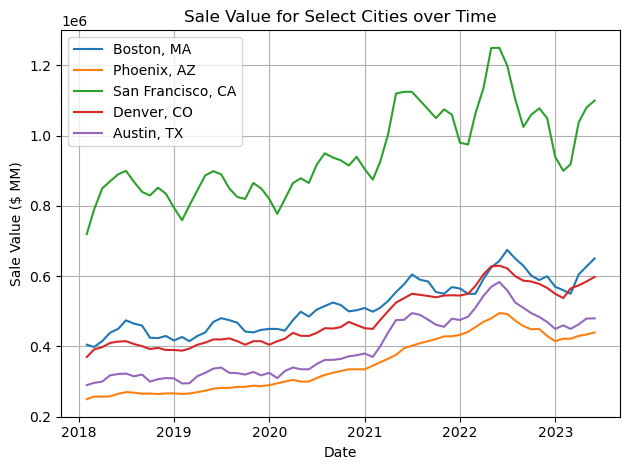

In [36]:
# Plot the sale value for each city
plt.plot(boston["Date"], boston["Boston, MA"], label="Boston, MA")
plt.plot(phoenix["Date"], phoenix["Phoenix, AZ"], label="Phoenix, AZ")
plt.plot(sanfran["Date"], sanfran["San Francisco, CA"], label="San Francisco, CA")
plt.plot(denver["Date"], denver["Denver, CO"], label="Denver, CO")
plt.plot(austin["Date"], austin["Austin, TX"], label="Austin, TX")

# Format the plot Area
plt.xlabel("Date")
plt.ylabel("Sale Value ($ MM)")
plt.title("Sale Value for Select Cities over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**What is the relationship between Inventory and Sale Price**

In [37]:
# Create a copy of inv_t to manipulate
inventory_merge = inv_t.copy()
inventory_merge.rename(columns = {"Boston, MA":"Boston Inv", "Phoenix, AZ":"Phoenix Inv",
                                "San Francisco, CA":"San Francisco Inv", "Denver, CO":"Denver Inv",
                                "Austin, TX":"Austin Inv"},
                       inplace=True)
inventory_merge

,Date,Boston Inv,Phoenix Inv,San Francisco Inv,Denver Inv,Austin Inv
1,2018-01-31,7993.0,25768.0,4111.0,7401.0,6704.0
2,2018-02-28,8777.0,26865.0,5277.0,7918.0,7149.0
3,2018-03-31,10432.0,28519.0,6589.0,9478.0,8322.0
4,2018-04-30,12821.0,28333.0,7224.0,10400.0,9361.0
5,2018-05-31,15297.0,27669.0,8162.0,11502.0,10047.0
...,...,...,...,...,...,...
62,2023-02-28,5836.0,19896.0,5010.0,6576.0,8833.0
63,2023-03-31,7543.0,19846.0,5642.0,7681.0,10105.0
64,2023-04-30,8073.0,18567.0,5955.0,8116.0,11084.0
65,2023-05-31,8897.0,17171.0,6524.0,8897.0,11860.0


In [38]:
# Create a copy of saleprice_t to manipulate
sale_merge = saleprice_t.copy()
sale_merge.rename(columns = {"Boston, MA":"Boston Price", "Phoenix, AZ":"Phoenix Price",
                                "San Francisco, CA":"San Francisco Price", "Denver, CO":"Denver Price",
                                "Austin, TX":"Austin Price"},
                       inplace=True)
sale_merge

,Date,Boston Price,Phoenix Price,San Francisco Price,Denver Price,Austin Price
1,2008-02-29,310000.0,225000.0,542000.0,225000.0,178950.0
2,2008-03-31,329900.0,225000.0,535000.0,226000.0,188000.0
3,2008-04-30,329000.0,227000.0,525000.0,227750.0,184995.0
4,2008-05-31,344360.0,227847.0,515000.0,230000.0,190000.0
5,2008-06-30,359900.0,225000.0,490000.0,235700.0,192500.0
...,...,...,...,...,...,...
180,2023-01-31,560000.0,422000.0,900000.0,537863.0,460000.0
181,2023-02-28,550000.0,422000.0,919000.0,565000.0,450000.0
182,2023-03-31,605000.0,430000.0,1038000.0,574000.0,462990.0
183,2023-04-30,627750.0,434000.0,1080000.0,585000.0,479495.0


In [39]:
# Merge the sale_merge and inv_merge DataFrames
market = pd.merge(inventory_merge, sale_merge, on="Date")
market.dropna(inplace=True)
market.head()

,Date,Boston Inv,Phoenix Inv,San Francisco Inv,Denver Inv,Austin Inv,Boston Price,Phoenix Price,San Francisco Price,Denver Price,Austin Price
0,2018-01-31,7993.0,25768.0,4111.0,7401.0,6704.0,405000.0,250000.0,720000.0,370000.0,290000.0
1,2018-02-28,8777.0,26865.0,5277.0,7918.0,7149.0,398500.0,257500.0,789818.0,391500.0,296434.0
2,2018-03-31,10432.0,28519.0,6589.0,9478.0,8322.0,415000.0,257000.0,850000.0,398000.0,300000.0
3,2018-04-30,12821.0,28333.0,7224.0,10400.0,9361.0,439000.0,258000.0,870000.0,410000.0,317750.0
4,2018-05-31,15297.0,27669.0,8162.0,11502.0,10047.0,450000.0,265000.0,890000.0,414000.0,321500.0


In [40]:
# Check the dtypes and make changes as needed
columns_to_convert = ['Boston Inv', 'Phoenix Inv', 'San Francisco Inv', 'Denver Inv', 'Austin Inv',
                      'Boston Price', 'Phoenix Price', 'San Francisco Price', 'Denver Price', 'Austin Price']

# Convert each column to numeric
market[columns_to_convert] = market[columns_to_convert].apply(pd.to_numeric)

market.dtypes

0
Date                   datetime64[ns]
Boston Inv                    float64
Phoenix Inv                   float64
San Francisco Inv             float64
Denver Inv                    float64
Austin Inv                    float64
Boston Price                  float64
Phoenix Price                 float64
San Francisco Price           float64
Denver Price                  float64
Austin Price                  float64
dtype: object

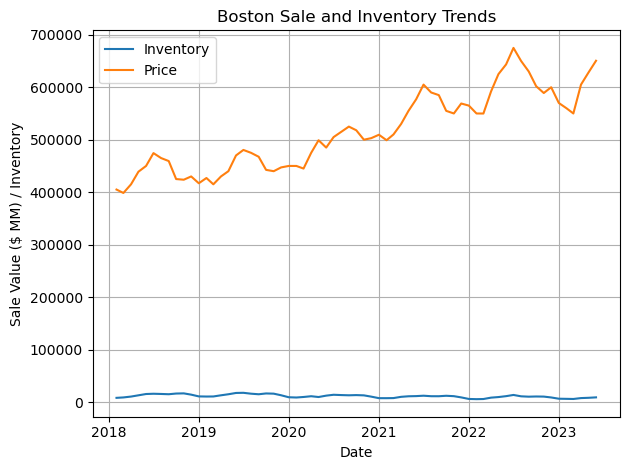

In [41]:
# Make a Scatter Plot for each city comparing Inventory and Sale Price
x = market["Boston Inv"]
y = market["Boston Price"]

# Plot the time series 
plt.plot(market["Date"], x, label="Inventory")
plt.plot(market["Date"], y, label="Price")

# Format the plot Area
plt.xlabel("Date")
plt.ylabel("Sale Value ($ MM) / Inventory")
plt.title("Boston Sale and Inventory Trends")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

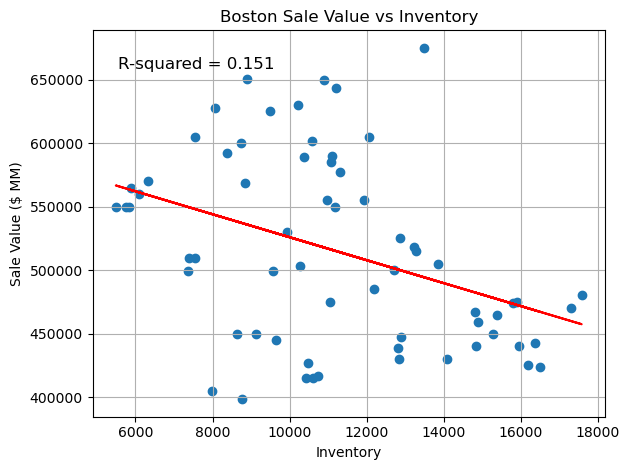

In [42]:
# Find the relationship between inventory and price
x = market["Boston Inv"]
y = market["Boston Price"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Calculate the R-squared value
r_squared = r_value ** 2

# Calculate the predicted values based on the regression line
predicted_values = slope * x + intercept

# Plot the scatter and regression line using the predicted values
plt.scatter(x, y)
plt.plot(x, predicted_values, color="red", label="Regression Line")
plt.text(0.05, 0.9, f"R-squared = {r_squared:.3f}", transform=plt.gca().transAxes, fontsize=12)

# Format the plot Area
plt.xlabel("Inventory")
plt.ylabel("Sale Value ($ MM)")
plt.title("Boston Sale Value vs Inventory")
plt.grid(True)
plt.tight_layout()
plt.show()


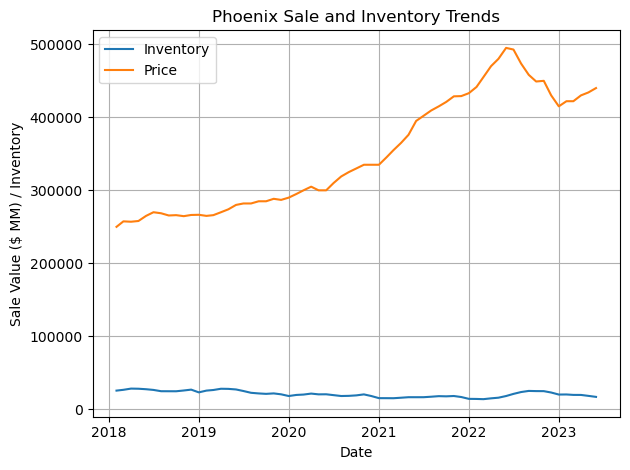

In [43]:
# Make a Scatter Plot for each city comparing Inventory and Sale Price
x = market["Phoenix Inv"]
y = market["Phoenix Price"]

# Plot the time series 
plt.plot(market["Date"], x, label="Inventory")
plt.plot(market["Date"], y, label="Price")

# Format the plot Area
plt.xlabel("Date")
plt.ylabel("Sale Value ($ MM) / Inventory")
plt.title("Phoenix Sale and Inventory Trends")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

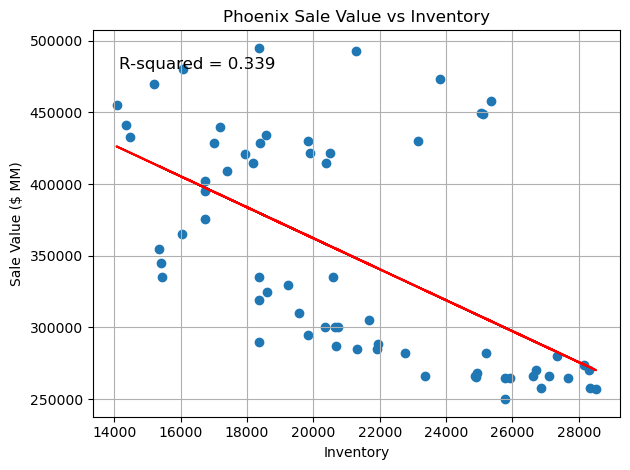

In [44]:
# Find the relationship between inventory and price
x = market["Phoenix Inv"]
y = market["Phoenix Price"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Calculate the R-squared value
r_squared = r_value ** 2

# Calculate the predicted values based on the regression line
predicted_values = slope * x + intercept

# Plot the scatter and regression line using the predicted values
plt.scatter(x, y)
plt.plot(x, predicted_values, color="red", label="Regression Line")
plt.text(0.05, 0.9, f"R-squared = {r_squared:.3f}", transform=plt.gca().transAxes, fontsize=12)

# Format the plot Area
plt.xlabel("Inventory")
plt.ylabel("Sale Value ($ MM)")
plt.title("Phoenix Sale Value vs Inventory")
plt.grid(True)
plt.tight_layout()
plt.show()

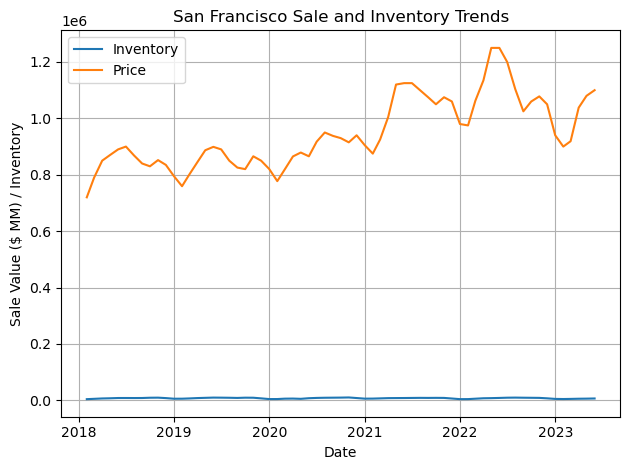

In [45]:
# Make a Scatter Plot for each city comparing Inventory and Sale Price
x = market["San Francisco Inv"]
y = market["San Francisco Price"]

# Plot the time series 
plt.plot(market["Date"], x, label="Inventory")
plt.plot(market["Date"], y, label="Price")

# Format the plot Area
plt.xlabel("Date")
plt.ylabel("Sale Value ($ MM) / Inventory")
plt.title("San Francisco Sale and Inventory Trends")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

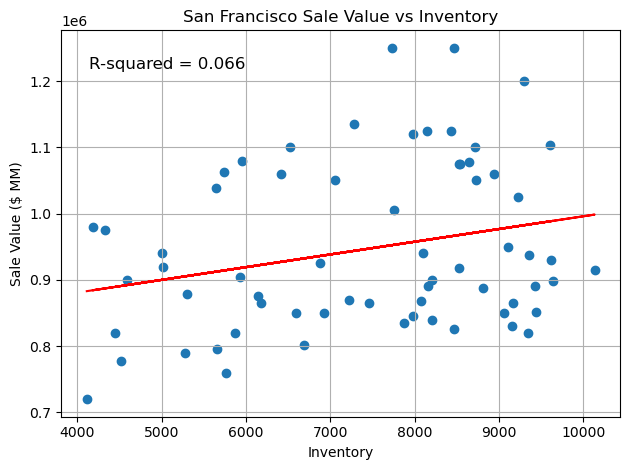

In [46]:
# Find the relationship between inventory and price
x = market["San Francisco Inv"]
y = market["San Francisco Price"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Calculate the R-squared value
r_squared = r_value ** 2

# Calculate the predicted values based on the regression line
predicted_values = slope * x + intercept

# Plot the scatter and regression line using the predicted values
plt.scatter(x, y)
plt.plot(x, predicted_values, color="red", label="Regression Line")
plt.text(0.05, 0.9, f"R-squared = {r_squared:.3f}", transform=plt.gca().transAxes, fontsize=12)

# Format the plot Area
plt.xlabel("Inventory")
plt.ylabel("Sale Value ($ MM)")
plt.title("San Francisco Sale Value vs Inventory")
plt.grid(True)
plt.tight_layout()
plt.show()

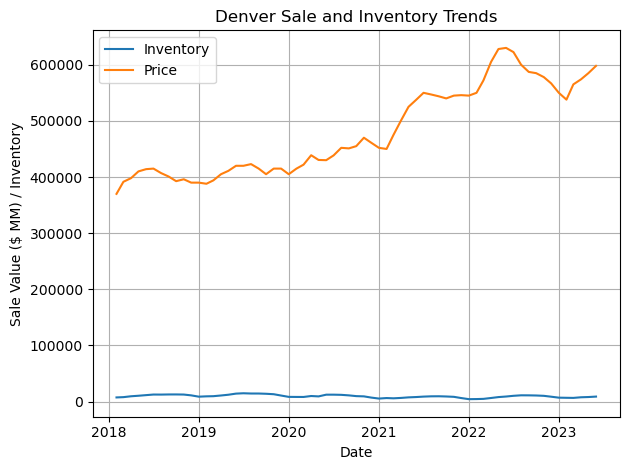

In [47]:
# Make a Scatter Plot for each city comparing Inventory and Sale Price
x = market["Denver Inv"]
y = market["Denver Price"]

# Plot the time series 
plt.plot(market["Date"], x, label="Inventory")
plt.plot(market["Date"], y, label="Price")

# Format the plot Area
plt.xlabel("Date")
plt.ylabel("Sale Value ($ MM) / Inventory")
plt.title("Denver Sale and Inventory Trends")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

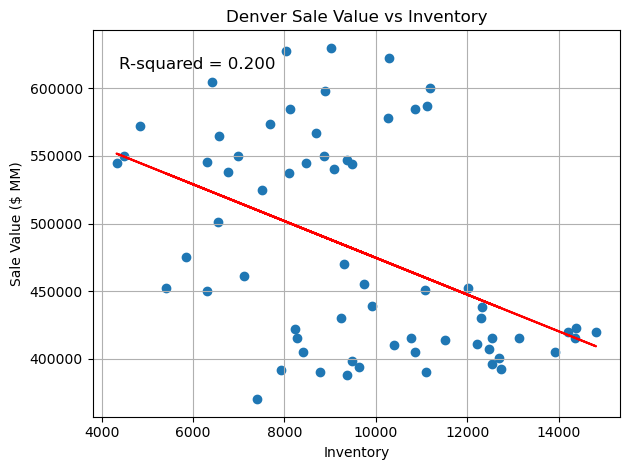

In [48]:
# Find the relationship between inventory and price
x = market["Denver Inv"]
y = market["Denver Price"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Calculate the R-squared value
r_squared = r_value ** 2

# Calculate the predicted values based on the regression line
predicted_values = slope * x + intercept

# Plot the scatter and regression line using the predicted values
plt.scatter(x, y)
plt.plot(x, predicted_values, color="red", label="Regression Line")
plt.text(0.05, 0.9, f"R-squared = {r_squared:.3f}", transform=plt.gca().transAxes, fontsize=12)

# Format the plot Area
plt.xlabel("Inventory")
plt.ylabel("Sale Value ($ MM)")
plt.title("Denver Sale Value vs Inventory")
plt.grid(True)
plt.tight_layout()
plt.show()

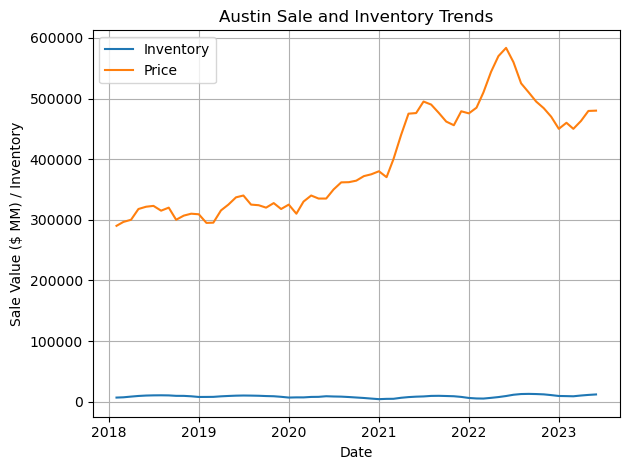

In [49]:
# Make a Scatter Plot for each city comparing Inventory and Sale Price
x = market["Austin Inv"]
y = market["Austin Price"]

# Plot the time series 
plt.plot(market["Date"], x, label="Inventory")
plt.plot(market["Date"], y, label="Price")

# Format the plot Area
plt.xlabel("Date")
plt.ylabel("Sale Value ($ MM) / Inventory")
plt.title("Austin Sale and Inventory Trends")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

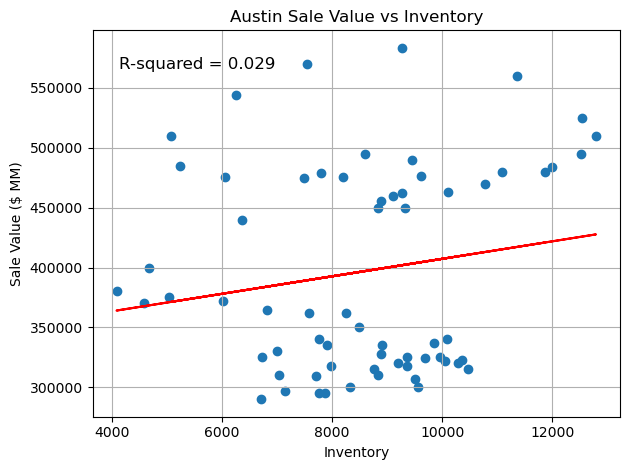

In [50]:
# Find the relationship between inventory and price
x = market["Austin Inv"]
y = market["Austin Price"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Calculate the R-squared value
r_squared = r_value ** 2

# Calculate the predicted values based on the regression line
predicted_values = slope * x + intercept

# Plot the scatter and regression line using the predicted values
plt.scatter(x, y)
plt.plot(x, predicted_values, color="red", label="Regression Line")
plt.text(0.05, 0.9, f"R-squared = {r_squared:.3f}", transform=plt.gca().transAxes, fontsize=12)

# Format the plot Area
plt.xlabel("Inventory")
plt.ylabel("Sale Value ($ MM)")
plt.title("Austin Sale Value vs Inventory")
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
# Determine if a relationship between inventory and population size exists using the entire dataset
# Create a stripped down version of the inventory DataFrame
inventory_x = inventory_df.copy()
inv_x = inventory_x[["RegionName", "SizeRank","2023-05-31"]]
inv_x.dropna(inplace=True)

# Create a stripped down version of the Sale Price DataFrame
saleprice_x = saleprice_df.copy()
sale_x = saleprice_x[["RegionName", "SizeRank","2023-05-31"]]
sale_x.dropna(inplace=True)

# Merge the two DataFrame
market_total = pd.merge(inv_x, sale_x, on="RegionName")
market_total.rename(columns = {"2023-05-31_x":"Inventory", "2023-05-31_y":"Sale Price", "SizeRank_x": "SizeRank"},
                       inplace=True)
market_total

C:\Users\grant\AppData\Local\Temp\ipykernel_13776\3781490095.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inv_x.dropna(inplace=True)
C:\Users\grant\AppData\Local\Temp\ipykernel_13776\3781490095.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sale_x.dropna(inplace=True)


,RegionName,SizeRank,Inventory,SizeRank_y,Sale Price
0,United States,0,907907.0,0,360000.0
1,"New York, NY",1,46808.0,1,565000.0
2,"Los Angeles, CA",2,15398.0,2,869000.0
3,"Chicago, IL",3,22727.0,3,319000.0
4,"Dallas, TX",4,21925.0,4,395000.0
...,...,...,...,...,...
641,"Sterling, CO",890,113.0,890,228000.0
642,"Beatrice, NE",891,76.0,891,193000.0
643,"Borger, TX",899,102.0,899,175000.0
644,"Price, UT",912,102.0,912,190000.0


In [52]:
market_cities = market_total.loc[market_total["RegionName"] != "United States"]
market_cities

,RegionName,SizeRank,Inventory,SizeRank_y,Sale Price
1,"New York, NY",1,46808.0,1,565000.0
2,"Los Angeles, CA",2,15398.0,2,869000.0
3,"Chicago, IL",3,22727.0,3,319000.0
4,"Dallas, TX",4,21925.0,4,395000.0
5,"Houston, TX",5,21863.0,5,330000.0
...,...,...,...,...,...
641,"Sterling, CO",890,113.0,890,228000.0
642,"Beatrice, NE",891,76.0,891,193000.0
643,"Borger, TX",899,102.0,899,175000.0
644,"Price, UT",912,102.0,912,190000.0


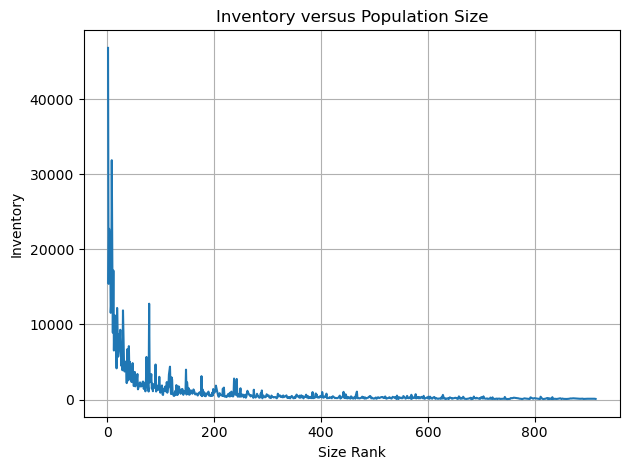

In [53]:
# Make a plot of Inventory vs Size
x = market_cities["SizeRank"]
y = market_cities["Inventory"]

# Plot the time series 
plt.plot(x, y)

# Format the plot Area
plt.xlabel("Size Rank")
plt.ylabel("Inventory")
plt.title("Inventory versus Population Size")
plt.grid(True)
plt.tight_layout()
plt.show()

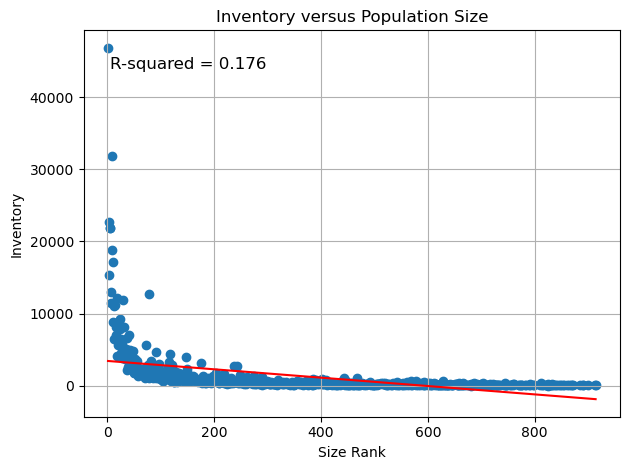

In [54]:
# Find the relationship between inventory and price
x = market_cities["SizeRank"]
y = market_cities["Inventory"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Calculate the R-squared value
r_squared = r_value ** 2

# Calculate the predicted values based on the regression line
predicted_values = slope * x + intercept

# Plot the scatter and regression line using the predicted values
plt.scatter(x, y)
plt.plot(x, predicted_values, color="red", label="Regression Line")
plt.text(0.05, 0.9, f"R-squared = {r_squared:.3f}", transform=plt.gca().transAxes, fontsize=12)

# Format the plot Area
plt.xlabel("Size Rank")
plt.ylabel("Inventory")
plt.title("Inventory versus Population Size")
plt.grid(True)
plt.tight_layout()
plt.show()

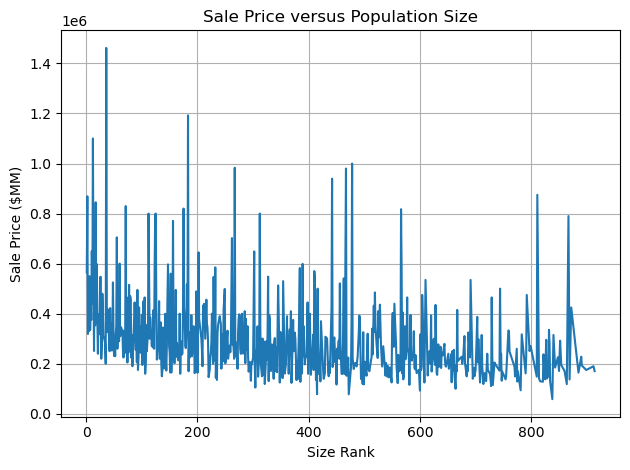

In [55]:
# Make a plot of Inventory vs Size
x = market_cities["SizeRank"]
y = market_cities["Sale Price"]

# Plot the time series 
plt.plot(x, y)

# Format the plot Area
plt.xlabel("Size Rank")
plt.ylabel("Sale Price ($MM)")
plt.title("Sale Price versus Population Size")
plt.grid(True)
plt.tight_layout()
plt.show()

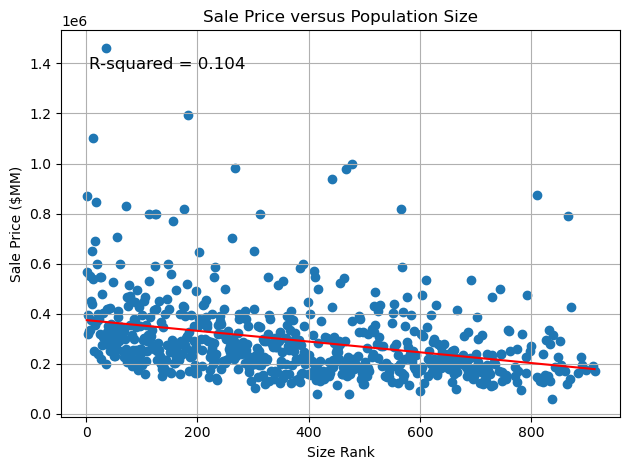

In [56]:
# Find the relationship between inventory and price
x = market_cities["SizeRank"]
y = market_cities["Sale Price"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Calculate the R-squared value
r_squared = r_value ** 2

# Calculate the predicted values based on the regression line
predicted_values = slope * x + intercept

# Plot the scatter and regression line using the predicted values
plt.scatter(x, y)
plt.plot(x, predicted_values, color="red", label="Regression Line")
plt.text(0.05, 0.9, f"R-squared = {r_squared:.3f}", transform=plt.gca().transAxes, fontsize=12)

# Format the plot Area
plt.xlabel("Size Rank")
plt.ylabel("Sale Price ($MM)")
plt.title("Sale Price versus Population Size")
plt.grid(True)
plt.tight_layout()
plt.show()

In [57]:
# What About the Top 50 MSAs
market_50 = market_cities.loc[market_cities["SizeRank"] <= 50]
market_50

,RegionName,SizeRank,Inventory,SizeRank_y,Sale Price
1,"New York, NY",1,46808.0,1,565000.0
2,"Los Angeles, CA",2,15398.0,2,869000.0
3,"Chicago, IL",3,22727.0,3,319000.0
4,"Dallas, TX",4,21925.0,4,395000.0
5,"Houston, TX",5,21863.0,5,330000.0
6,"Washington, DC",6,11542.0,6,550000.0
7,"Philadelphia, PA",7,12931.0,7,335000.0
8,"Miami, FL",8,31855.0,8,450000.0
9,"Atlanta, GA",9,18805.0,9,375000.0
10,"Boston, MA",10,8897.0,10,650500.0


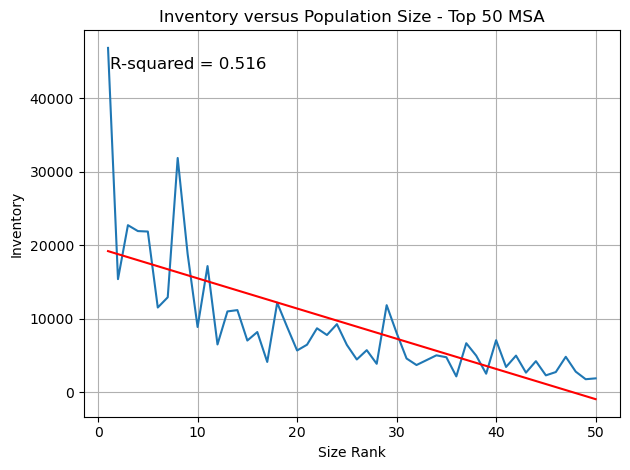

In [58]:
# Make a plot of Inventory vs Size for Market 50
x = market_50["SizeRank"]
y = market_50["Inventory"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Calculate the R-squared value
r_squared = r_value ** 2

# Calculate the predicted values based on the regression line
predicted_values = slope * x + intercept

# Plot the scatter and regression line using the predicted values
plt.plot(x, y)
plt.plot(x, predicted_values, color="red", label="Regression Line")
plt.text(0.05, 0.9, f"R-squared = {r_squared:.3f}", transform=plt.gca().transAxes, fontsize=12)

# Format the plot Area
plt.xlabel("Size Rank")
plt.ylabel("Inventory")
plt.title("Inventory versus Population Size - Top 50 MSA")
plt.grid(True)
plt.tight_layout()
plt.show()

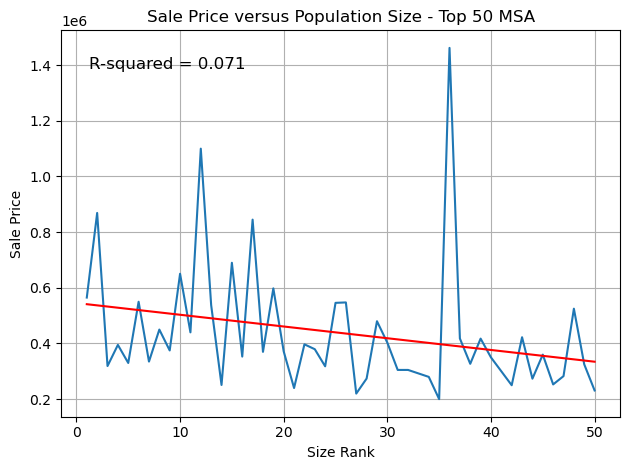

In [59]:
# Make a plot of Price vs Size for Market 50
x = market_50["SizeRank"]
y = market_50["Sale Price"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Calculate the R-squared value
r_squared = r_value ** 2

# Calculate the predicted values based on the regression line
predicted_values = slope * x + intercept

# Plot the scatter and regression line using the predicted values
plt.plot(x, y)
plt.plot(x, predicted_values, color="red", label="Regression Line")
plt.text(0.05, 0.9, f"R-squared = {r_squared:.3f}", transform=plt.gca().transAxes, fontsize=12)

# Format the plot Area
plt.xlabel("Size Rank")
plt.ylabel("Sale Price")
plt.title("Sale Price versus Population Size - Top 50 MSA")
plt.grid(True)
plt.tight_layout()
plt.show()

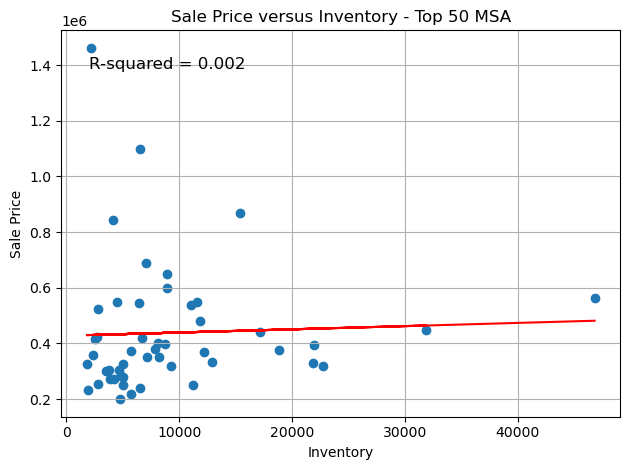

In [62]:
# Make a plot of Price vs Size for Market 50
x = market_50["Inventory"]
y = market_50["Sale Price"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Calculate the R-squared value
r_squared = r_value ** 2

# Calculate the predicted values based on the regression line
predicted_values = slope * x + intercept

# Plot the scatter and regression line using the predicted values
plt.scatter(x, y)
plt.plot(x, predicted_values, color="red", label="Regression Line")
plt.text(0.05, 0.9, f"R-squared = {r_squared:.3f}", transform=plt.gca().transAxes, fontsize=12)

# Format the plot Area
plt.xlabel("Inventory")
plt.ylabel("Sale Price")
plt.title("Sale Price versus Inventory - Top 50 MSA")
plt.grid(True)
plt.tight_layout()
plt.show()

**BONUS - Let's check in on our friends in Texas**

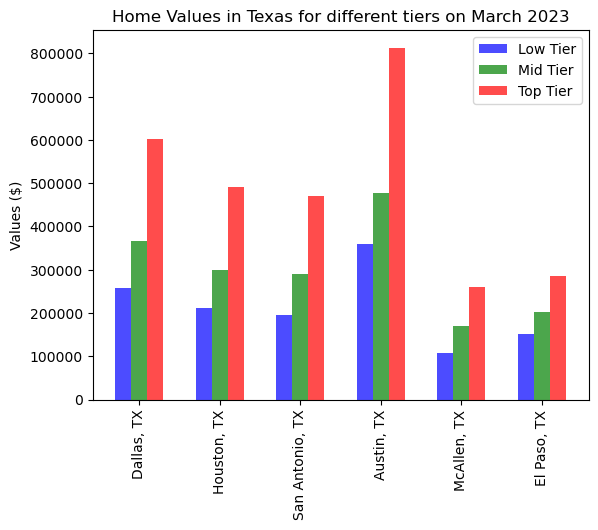

In [61]:
# Example Bar Chart to compare a State's MSAs
texas = zhvi_all_df.loc[(zhvi_all_df["StateName"] == "TX") &
                        (zhvi_all_df["SizeRank"] <= 100)]

# Create an offset for each bar
bar_width = 0.2
offset = np.arange(len(texas['RegionName']))

# Plot all three y-values on the same graph with an offset for each bar
plt.bar(offset - bar_width, texas['2023-03-31_low'], width=bar_width, color='blue', alpha=0.7, label='Low Tier')
plt.bar(offset, texas['2023-03-31'], width=bar_width, color='green', alpha=0.7, label='Mid Tier')
plt.bar(offset + bar_width, texas['2023-03-31_top'], width=bar_width, color='red', alpha=0.7, label='Top Tier')

# Put labels and descriptors on the 
plt.ylabel('Values ($)')
plt.title('Home Values in Texas for different tiers on March 2023')
plt.xticks(offset, texas['RegionName'], rotation=90)
plt.legend()

# Display the plot
plt.show()